# Ca channels: inactivation

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ca channel recordings in the "data/Ca_channels" folder

In [2]:
data_folder = "data/3-Ca_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/3-Ca_channels


['data/3-Ca_channels/2025_06_09_0008.abf',
 'data/3-Ca_channels/2025_06_09_0009.abf',
 'data/3-Ca_channels/CAV_Tho_IV.abf',
 'data/3-Ca_channels/2025_06_09_0002.abf',
 'data/3-Ca_channels/2024_06_10_0027.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
# data_file = 'data/3-Ca_channels/CAV_Tho_IV.abf'
data_file = 'data/3-Ca_channels/2025_06_09_0008.abf'

Now we can load the file and plot the raw data:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

Trace('2025_06_09_0008.abf')
Number of sweeps: 10
Points per sweep: 60,000
Duration per sweep: 6.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage


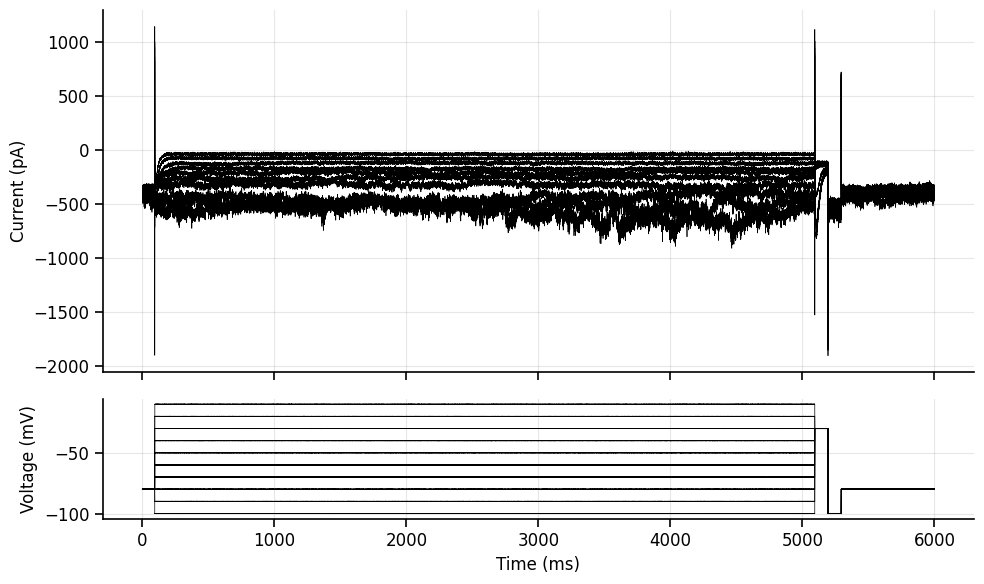

Voltage step time: [5093.7] to [5193.7] ms


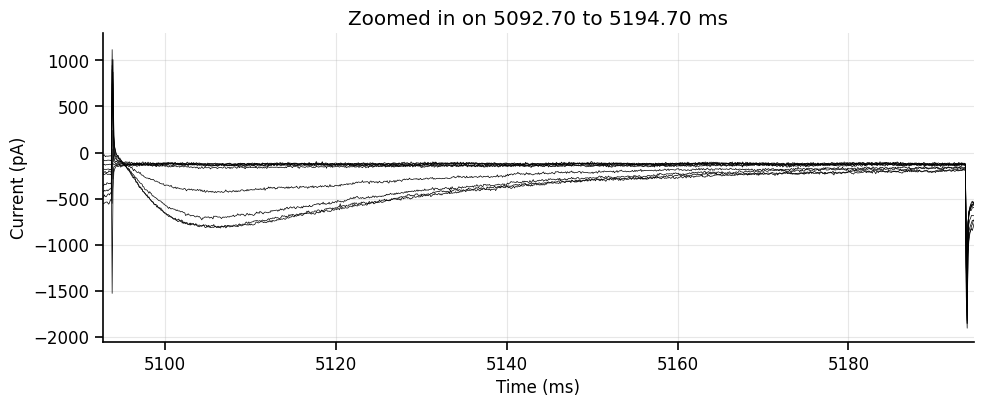

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              units=['pA', 'mV'])
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)


# ----------------------------------------------------------------------------------------------------------------
# The %matplotlib widget lines makes plots interactive (but sometimes is a bit buggy, doesn't always work)

# %matplotlib widget
%matplotlib inline
ax = traces.plot(plot_voltage=True, sweep='all', time_units=time_units)
plt.show()

v_step_start_init = traces.get_step_events(threshold=traces.voltage_data[0,0]-5, channel='voltage', edge='falling', polarity='positive', time_units=time_units, sweep=0)
v_step_start = traces.get_step_events(threshold=traces.voltage_data[0,0]+5, channel='voltage', edge='rising', polarity='positive', time_units=time_units, sweep=0)
v_step_end = traces.get_step_events(threshold=traces.voltage_data[0,-1]+5, channel='voltage', edge='falling', polarity='positive', time_units=time_units, sweep=0)
print(f"Voltage step time: {v_step_start} to {v_step_end} ms")
try:
    x_axis_range = (v_step_start[0]-1, v_step_end[0]+1)
except:
    x_axis_range = (v_step_start[0], v_step_end[0])

ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
ax.set_xlim(x_axis_range)
ax.set_title(f'Zoomed in on {x_axis_range[0]:.2f} to {x_axis_range[1]:.2f} {time_units}')
plt.show()

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline currents (pA): [-385.614  -477.2766 -434.9854 ... -375.2563 -345.4773 -380.3284]


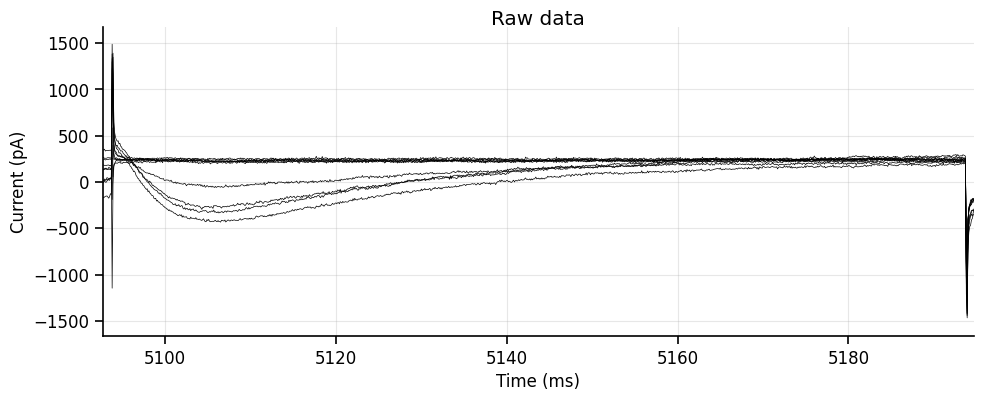

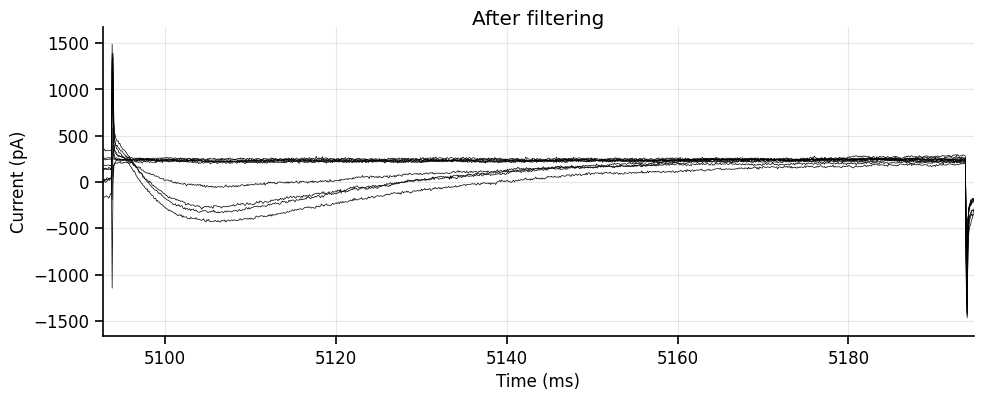

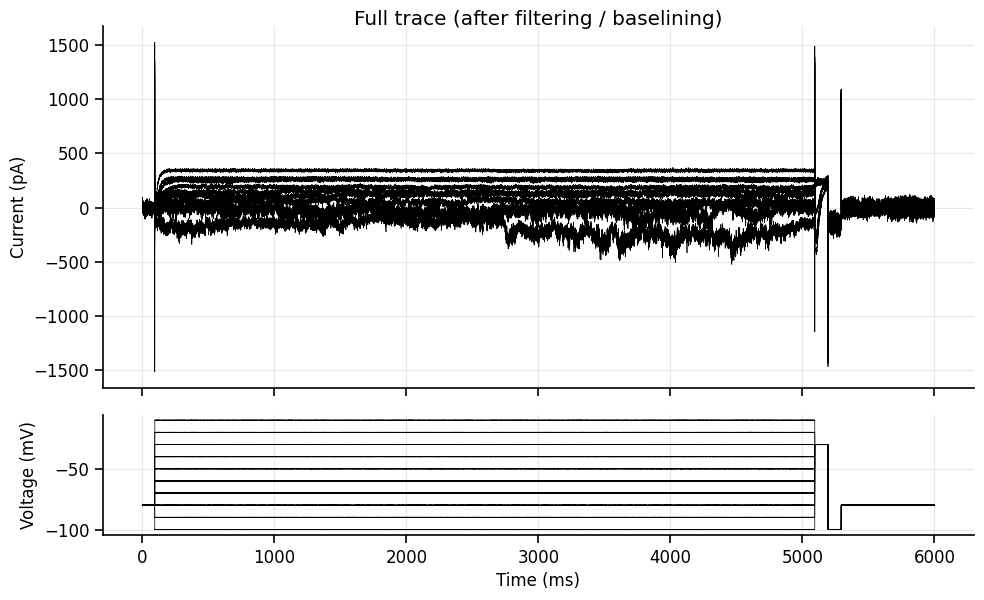

In [ ]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = False   # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 4000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    start_baseline = max(0, v_step_start_init[0]-5)  # Start time for baseline subtraction
    end_baseline = v_step_start_init[0]  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'current')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline

    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_xlim(x_axis_range)
    ax.set_title('Raw data', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_xlim(x_axis_range)
    ax.set_title('After filtering', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=True, time_units=time_units, sweep='all')
    ax[0].set_title('Full trace (after filtering / baselining)', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [6]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 3. Measure the peak currents

First we will define the time window where we want to measure the peak (both positive and negative) currents

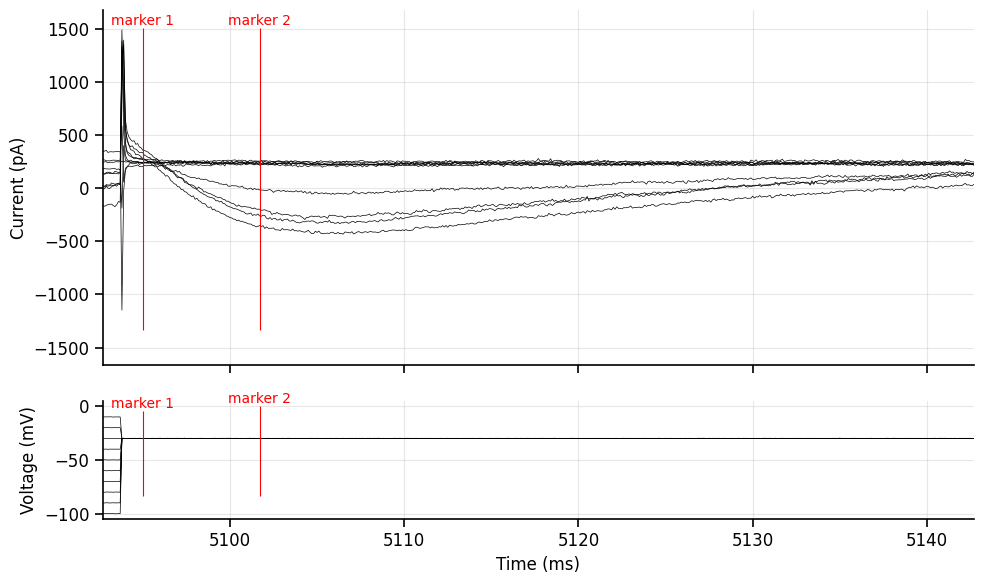

In [16]:
# The markers here will define the window where we will measure peak current values. If they don't look right you can adjust them to make sure you include all the current peaks without the stim artifact.
marker_1 = v_step_start[0] + 1.3
marker_2 = v_step_start[0] + 8

# ----------------------------------------------------------------------------------------------------------------------
# change to %matplotlib inline if the interactive plot is not showing
%matplotlib inline
# %matplotlib widget   
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.set_xlim(x_axis_range[0], x_axis_range[0]+50)  # Extend the x-axis a bit to the right
ax2.set_xlim(x_axis_range[0], x_axis_range[0]+50)  # Extend the x-axis a bit to the right
plt.show()

Now we can use the timepoints from the markers we defined above to measure the peak current for each voltage step.

## 4. Calculate activation curve

Unlike a "regular" IV, here we want to plot the peak currents against the holding voltages from the **first phase** of the step protocol:

In [20]:
# Define the timepoint where the voltage is measured
voltage_timepoint = v_step_start[0] - 5

# ------------------------------------------------------------------------------------------------
_,voltage_steps = traces.get_measurements(start_time=voltage_timepoint, end_time=voltage_timepoint+1, time_units=time_units, sweep='all')

Text(0, 0.5, 'Current (pA)')

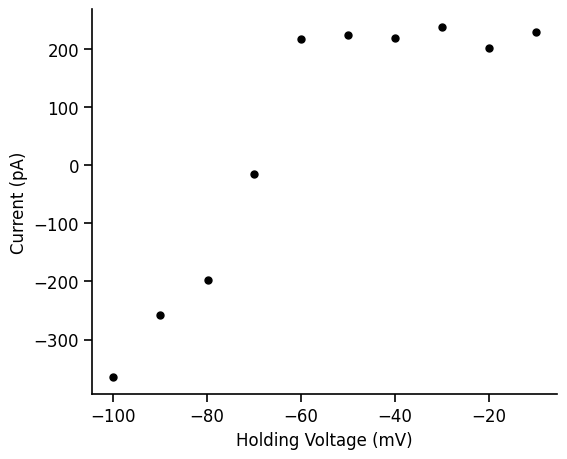

In [23]:
measurement_type = 'min' # Options: 'mean', 'max', 'min', 'peak'

current_steps,_ = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                        measurement_type=measurement_type, time_units=time_units)

# Plot the normalized current steps against the holding voltages
%matplotlib inline
fig,ax = plt.subplots(figsize=(6, 5))
ax.plot(voltage_steps, current_steps, 'o', color='black', markersize=5)
ax.set_xlabel(f'Holding Voltage ({traces.voltage_unit})')
ax.set_ylabel(f'Current ({traces.current_unit})')

Now we can normalize the values between 0 and 1 and fit a Boltzmann (sigmoid) function

Boltzmann Fit parameters:
V_half: -73.661, k: -6.995


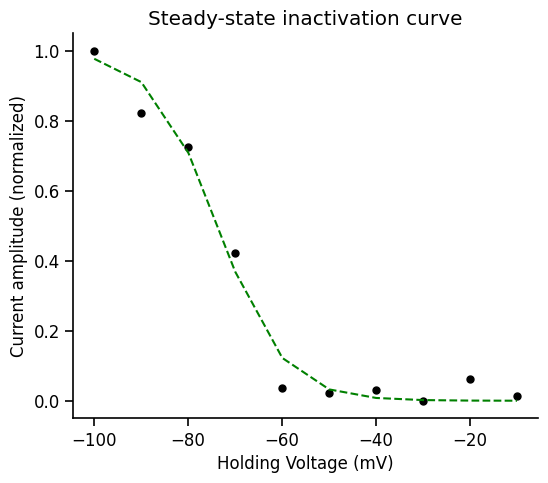

In [25]:
# Normalize to the biggest current (min-max normalization)
current_steps_norm = (current_steps - np.max(current_steps)) / (np.min(current_steps) - np.max(current_steps))

# Plot the normalized current steps against the holding voltages
%matplotlib inline
fig,ax = plt.subplots(figsize=(6, 5))
ax.plot(voltage_steps, current_steps_norm, 'o', color='black', markersize=5)
ax.set_xlabel(f'Holding Voltage ({traces.voltage_unit})')
ax.set_ylabel('Current amplitude (normalized)')
ax.set_title('Steady-state inactivation curve')

# Optional: fit a Boltzmann function (sigmoid curve) to the data
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
k_guess = -5 # Initial guess for the slope parameter
popt, _ = curve_fit(boltzmann, voltage_steps, current_steps_norm, p0=[np.median(voltage_steps), k_guess])
ax.plot(voltage_steps, boltzmann(voltage_steps, *popt), linestyle='--', color='g', label='Fit')
print("Boltzmann Fit parameters:")
print(f"V_half: {popt[0]:.3f}, k: {popt[1]:.3f}")
plt.show()